In [1]:
# Imports
import os, random, numpy as np, pandas as pd
from dataclasses import dataclass
from typing import List
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt
import optuna
from sklearn.metrics import roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import label_binarize
import json

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Config the variable
CSV_PATH  = "2_processed_data/labelled_dataset_revised.csv"
TEXT_COL  = "sentence"
LABEL_COL = "revised_argument_type"
VALID_LABELS = ['C','G','W/Q','OTH']
MODEL_SAVE_DIR = "3_model/cnn"
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# Data Loading and Preparation
df = pd.read_csv(CSV_PATH)[[TEXT_COL, LABEL_COL]].dropna()
if VALID_LABELS:
    df = df[df[LABEL_COL].isin(VALID_LABELS)].copy()

label2id = {l:i for i,l in enumerate(sorted(df[LABEL_COL].unique()))}
id2label = {i:l for l,i in label2id.items()}

y_all = df[LABEL_COL].map(label2id).astype(int).tolist()
X_all = df[TEXT_COL].astype(str).tolist()

X_train, X_val, y_train, y_val = train_test_split(
    X_all, y_all, test_size=0.2, stratify=y_all, random_state=SEED
)

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased", use_fast=True)
if tokenizer.pad_token_id is None:
    tokenizer.pad_token = tokenizer.eos_token


In [4]:
# Dataset & Collator
class TextDataset(Dataset):
    def __init__(self, texts: List[str], labels: List[int]):
        self.texts = texts
        self.labels = labels
    def __len__(self): return len(self.texts)
    def __getitem__(self, idx): return self.texts[idx], self.labels[idx]

@dataclass
class Collate:
    tokenizer: AutoTokenizer
    max_len: int
    def __call__(self, batch):
        texts, labels = zip(*batch)
        enc = self.tokenizer(
            list(texts), truncation=True, padding=True,
            max_length=self.max_len, return_tensors="pt"
        )
        return {
            "input_ids": enc["input_ids"],
            "attention_mask": enc["attention_mask"],
            "labels": torch.tensor(labels, dtype=torch.long),
        }

In [ ]:
# TextCNN Model
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes, filter_sizes=(3,4,5), num_filters=100, dropout=0.5, pad_id=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_id)
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embed_dim, out_channels=num_filters, kernel_size=k)
            for k in filter_sizes
        ])
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(num_filters * len(filter_sizes), num_classes)

        for conv in self.convs:
            nn.init.kaiming_normal_(conv.weight, nonlinearity='relu')
            if conv.bias is not None: nn.init.constant_(conv.bias, 0.0)

    def forward(self, input_ids, attention_mask=None):
        x = self.embedding(input_ids)      # (B, T, E)
        x = x.transpose(1, 2)              # (B, E, T)
        conv_outputs = [F.max_pool1d(F.relu(conv(x)), kernel_size=conv(x).shape[-1]).squeeze(-1) for conv in self.convs]
        h = torch.cat(conv_outputs, dim=1)
        h = self.dropout(h)
        return self.fc(h)

Epoch 1/5 | Loss: 0.7523
Epoch 2/5 | Loss: 0.4997
Epoch 3/5 | Loss: 0.4180
Epoch 4/5 | Loss: 0.3628
Epoch 5/5 | Loss: 0.3211
Validation Report:
              precision    recall  f1-score   support

           C       0.82      0.82      0.82      3388
           G       0.89      0.80      0.84      5736
         OTH       0.72      0.62      0.67      2753
         W/Q       0.85      0.93      0.89      9830

    accuracy                           0.84     21707
   macro avg       0.82      0.79      0.80     21707
weighted avg       0.84      0.84      0.84     21707



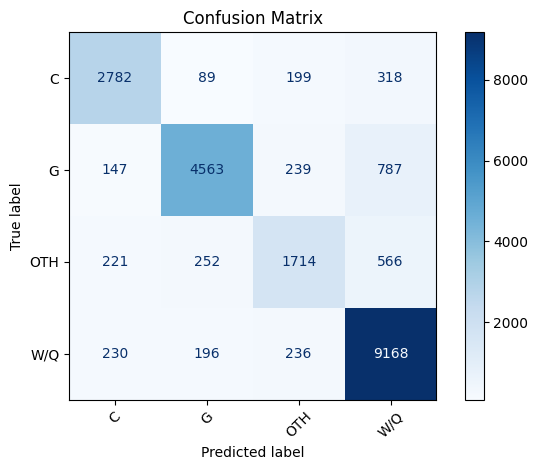

ROC-AUC (OvR, macro):    0.9678
ROC-AUC (OvR, weighted): 0.9710


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_plot\roc_curve.py:589: FutureWarning: y_pred is deprecated in 1.7 and will be removed in 1.9. Please use `y_score` instead.
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_plot\roc_curve.py:589: FutureWarning: y_pred is deprecated in 1.7 and will be removed in 1.9. Please use `y_score` instead.
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_plot\roc_curve.py:589: FutureWarning: y_pred is deprecated in 1.7 and will be removed in 1.9. Please use `y_score` instead.
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_plot\roc_curve.py:589: FutureWarning: y_pred is deprecated in 1.7 and will be removed in 1.9. Please use `y_score` instead.
  warnings.warn(


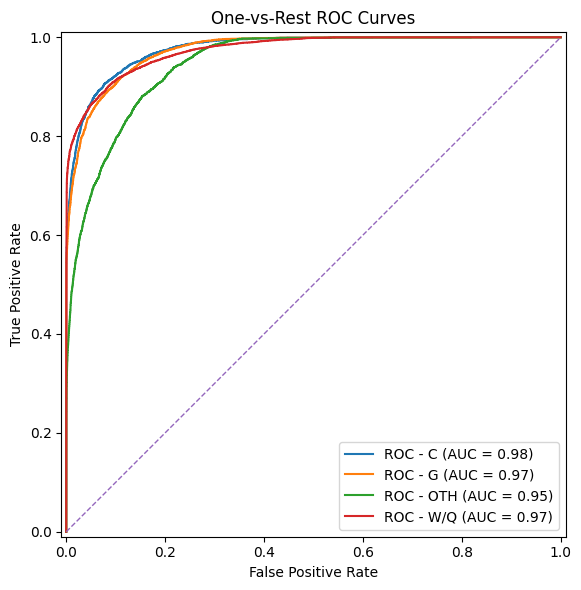

In [6]:
# One-Time Training & Eval
def train_eval_one_time(embed_dim=128, num_filters=100, dropout=0.5, batch_size=32, lr=1e-3, epochs=5):
    train_ds = TextDataset(X_train, y_train)
    val_ds   = TextDataset(X_val, y_val)
    collate  = Collate(tokenizer, max_len=128)
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate)
    val_dl   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, collate_fn=collate)

    model = TextCNN(len(tokenizer), embed_dim, len(label2id), num_filters=num_filters, dropout=dropout, pad_id=tokenizer.pad_token_id).to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # Training
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in train_dl:
            opt.zero_grad()
            batch = {k:v.to(DEVICE) for k,v in batch.items()}
            logits = model(batch["input_ids"])
            loss = criterion(logits, batch["labels"])
            loss.backward(); opt.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs} | Loss: {total_loss/len(train_dl):.4f}")

    # Evaluation (confusion matrix + ROC/AUC)
    model.eval()
    all_preds, all_labels = [], []
    all_probas = []

    with torch.no_grad():
        for batch in val_dl:
            batch = {k: v.to(DEVICE) for k, v in batch.items()}
            logits = model(batch["input_ids"])                # (B, num_classes)
            probas = torch.softmax(logits, dim=-1).cpu().numpy()  # (B, num_classes)
            preds = logits.argmax(dim=-1).cpu().tolist()

            all_probas.append(probas)
            all_preds.extend(preds)
            all_labels.extend(batch["labels"].cpu().tolist())

    # Confusion matrix (you likely already have this)
    print("Validation Report:")
    print(classification_report(
        all_labels, all_preds,
        target_names=[id2label[i] for i in range(len(label2id))]
    ))

    cm = confusion_matrix(all_labels, all_preds)
    ConfusionMatrixDisplay(
        cm, display_labels=[id2label[i] for i in range(len(label2id))]
    ).plot(cmap=plt.cm.Blues, xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    # ROC / AUC
    y_true = np.array(all_labels)                 # shape: (N,)
    y_score = np.vstack(all_probas)               # shape: (N, num_classes)
    num_classes = len(label2id)

    # Overall AUC (macro and weighted) using One-vs-Rest
    auc_ovr_macro    = roc_auc_score(y_true, y_score, multi_class="ovr", average="macro")
    auc_ovr_weighted = roc_auc_score(y_true, y_score, multi_class="ovr", average="weighted")
    print(f"ROC-AUC (OvR, macro):    {auc_ovr_macro:.4f}")
    print(f"ROC-AUC (OvR, weighted): {auc_ovr_weighted:.4f}")

    # Per-class ROC curves (OvR)
    # Binarize labels for plotting one-vs-rest curves
    y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))  # (N, num_classes)

    fig, ax = plt.subplots(figsize=(7, 6))
    for i in range(num_classes):
        RocCurveDisplay.from_predictions(
            y_true=y_true_bin[:, i],     # binary labels for class i
            y_pred=y_score[:, i],        # probability for class i
            name=f"ROC - {id2label[i]}",
            ax=ax
        )

    # Diagonal reference line
    ax.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
    ax.set_title("One-vs-Rest ROC Curves")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    plt.tight_layout()
    plt.show()

# Run once
train_eval_one_time()

In [7]:
# Hyperparameter Tuning
def objective(trial):
    embed_dim   = trial.suggest_categorical("embed_dim", [64,128,256])
    num_filters = trial.suggest_categorical("num_filters", [50,100,200])
    dropout     = trial.suggest_float("dropout", 0.3, 0.7)
    batch_size  = trial.suggest_categorical("batch_size", [16,32,64])
    lr          = trial.suggest_loguniform("lr", 1e-4, 1e-2)
    epochs      = 3

    # Same training loop but return val accuracy
    train_ds = TextDataset(X_train, y_train)
    val_ds   = TextDataset(X_val, y_val)
    collate  = Collate(tokenizer, max_len=128)
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate)
    val_dl   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, collate_fn=collate)

    model = TextCNN(len(tokenizer), embed_dim, len(label2id), num_filters=num_filters, dropout=dropout, pad_id=tokenizer.pad_token_id).to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        for batch in train_dl:
            opt.zero_grad()
            batch = {k:v.to(DEVICE) for k,v in batch.items()}
            logits = model(batch["input_ids"])
            loss = criterion(logits, batch["labels"])
            loss.backward(); opt.step()

    # Eval
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in val_dl:
            batch = {k:v.to(DEVICE) for k,v in batch.items()}
            preds = model(batch["input_ids"]).argmax(dim=-1).cpu().tolist()
            all_preds.extend(preds); all_labels.extend(batch["labels"].cpu().tolist())

    return accuracy_score(all_labels, all_preds)

# Run tuning
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)
print("Best params:", study.best_params)

[I 2025-09-01 18:21:10,874] A new study created in memory with name: no-name-54a0fa67-edd7-4527-bf77-e89fa4230f53
C:\Users\user\AppData\Local\Temp\ipykernel_39792\2838735251.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr          = trial.suggest_loguniform("lr", 1e-4, 1e-2)
[I 2025-09-01 18:21:51,929] Trial 0 finished with value: 0.8059151425807344 and parameters: {'embed_dim': 64, 'num_filters': 200, 'dropout': 0.6929606940939106, 'batch_size': 32, 'lr': 0.003039923624611219}. Best is trial 0 with value: 0.8059151425807344.
C:\Users\user\AppData\Local\Temp\ipykernel_39792\2838735251.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr          = trial.suggest

Best params: {'embed_dim': 256, 'num_filters': 100, 'dropout': 0.35397716592326217, 'batch_size': 32, 'lr': 0.0008308143957401575}


Best params from Optuna: {'embed_dim': 256, 'num_filters': 100, 'dropout': 0.35397716592326217, 'batch_size': 32, 'lr': 0.0008308143957401575}
[BestParam Training] Epoch 1/5 | Loss: 0.6500
[BestParam Training] Epoch 2/5 | Loss: 0.4420
[BestParam Training] Epoch 3/5 | Loss: 0.3516
[BestParam Training] Epoch 4/5 | Loss: 0.2845
[BestParam Training] Epoch 5/5 | Loss: 0.2288

=== Validation Report (Best Params) ===
              precision    recall  f1-score   support

           C       0.88      0.79      0.83      3388
           G       0.85      0.86      0.85      5736
         OTH       0.71      0.66      0.68      2753
         W/Q       0.88      0.92      0.90      9830

    accuracy                           0.85     21707
   macro avg       0.83      0.81      0.82     21707
weighted avg       0.85      0.85      0.85     21707

Accuracy: 0.8496


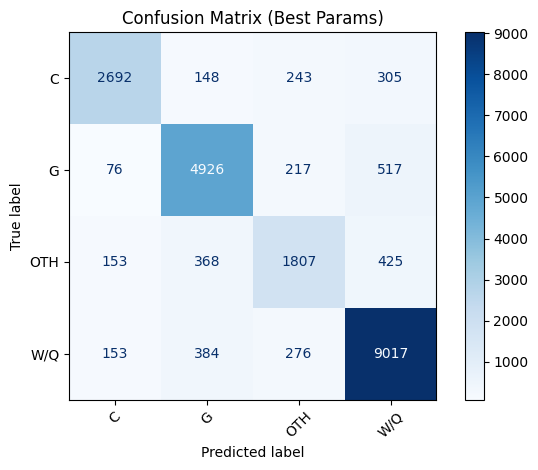

ROC-AUC (OvR, macro):    0.9695
ROC-AUC (OvR, weighted): 0.9725


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_plot\roc_curve.py:589: FutureWarning: y_pred is deprecated in 1.7 and will be removed in 1.9. Please use `y_score` instead.
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_plot\roc_curve.py:589: FutureWarning: y_pred is deprecated in 1.7 and will be removed in 1.9. Please use `y_score` instead.
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_plot\roc_curve.py:589: FutureWarning: y_pred is deprecated in 1.7 and will be removed in 1.9. Please use `y_score` instead.
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_plot\roc_curve.py:589: FutureWarning: y_pred is deprecated in 1.7 and will be removed in 1.9. Please use `y_score` instead.
  warnings.warn(


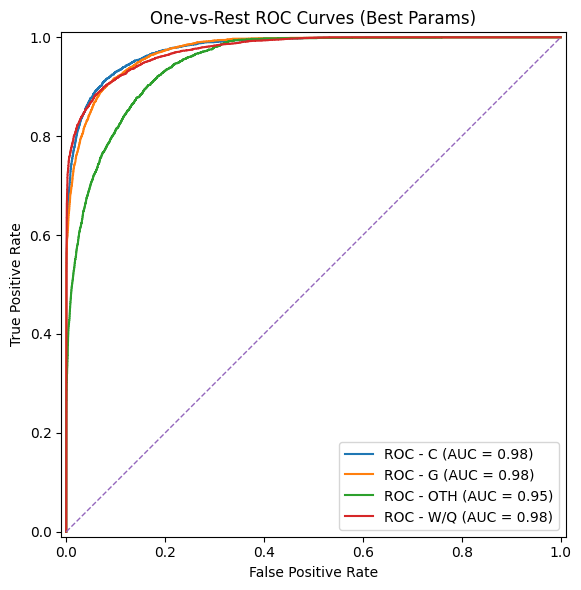


Saved best model + params. Metrics: {'val_accuracy': 0.8495876906067167, 'auc_ovr_macro': 0.9695345584037314, 'auc_ovr_weighted': 0.9725250785560436, 'confusion_matrix': array([[2692,  148,  243,  305],
       [  76, 4926,  217,  517],
       [ 153,  368, 1807,  425],
       [ 153,  384,  276, 9017]])}


In [8]:
# Evaluate the best Optuna params
def train_and_eval_with_params(params, final_epochs=5, max_len=128, save_dir="3_model/cnn"):
    os.makedirs(save_dir, exist_ok=True)

    embed_dim   = params["embed_dim"]
    num_filters = params["num_filters"]
    dropout     = params["dropout"]
    batch_size  = params["batch_size"]
    lr          = params["lr"]

    # Datasets / Dataloaders (reuse your global X_train, X_val, etc.)
    train_ds = TextDataset(X_train, y_train)
    val_ds   = TextDataset(X_val, y_val)
    collate  = Collate(tokenizer, max_len=max_len)
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  collate_fn=collate)
    val_dl   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, collate_fn=collate)

    # Model
    model = TextCNN(
        vocab_size=len(tokenizer),
        embed_dim=embed_dim,
        num_classes=len(label2id),
        num_filters=num_filters,
        dropout=dropout,
        pad_id=tokenizer.pad_token_id
    ).to(DEVICE)

    opt = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # Train
    for epoch in range(final_epochs):
        model.train()
        total_loss = 0.0
        for batch in train_dl:
            opt.zero_grad()
            batch = {k: v.to(DEVICE) for k, v in batch.items()}
            logits = model(batch["input_ids"])
            loss = criterion(logits, batch["labels"])
            loss.backward()
            opt.step()
            total_loss += loss.item()
        print(f"[BestParam Training] Epoch {epoch+1}/{final_epochs} | Loss: {total_loss/len(train_dl):.4f}")

    # Evaluate (Report + CM + ROC/AUC)
    model.eval()
    all_labels, all_preds = [], []
    all_probas = []

    with torch.no_grad():
        for batch in val_dl:
            batch = {k: v.to(DEVICE) for k, v in batch.items()}
            logits = model(batch["input_ids"])                    # (B, C)
            probas = torch.softmax(logits, dim=-1).cpu().numpy()  # (B, C)
            preds  = logits.argmax(dim=-1).cpu().tolist()
            all_probas.append(probas)
            all_preds.extend(preds)
            all_labels.extend(batch["labels"].cpu().tolist())

    y_true  = np.array(all_labels)
    y_score = np.vstack(all_probas)
    num_classes = len(label2id)

    # Accuracy + Report
    acc = accuracy_score(y_true, all_preds)
    print("\n=== Validation Report (Best Params) ===")
    print(classification_report(
        y_true, all_preds,
        target_names=[id2label[i] for i in range(num_classes)]
    ))
    print(f"Accuracy: {acc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_true, all_preds)
    disp = ConfusionMatrixDisplay(
        cm, display_labels=[id2label[i] for i in range(num_classes)]
    )
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
    plt.title("Confusion Matrix (Best Params)")
    plt.tight_layout()
    plt.show()

    # ROC / AUC (OvR)
    auc_ovr_macro    = roc_auc_score(y_true, y_score, multi_class="ovr", average="macro")
    auc_ovr_weighted = roc_auc_score(y_true, y_score, multi_class="ovr", average="weighted")
    print(f"ROC-AUC (OvR, macro):    {auc_ovr_macro:.4f}")
    print(f"ROC-AUC (OvR, weighted): {auc_ovr_weighted:.4f}")

    # Per-class ROC curves (One-vs-Rest)
    y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))  # shape: (N, C)
    fig, ax = plt.subplots(figsize=(7, 6))
    for i in range(num_classes):
        RocCurveDisplay.from_predictions(
            y_true=y_true_bin[:, i],
            y_pred=y_score[:, i],
            name=f"ROC - {id2label[i]}",
            ax=ax
        )
    ax.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
    ax.set_title("One-vs-Rest ROC Curves (Best Params)")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    plt.tight_layout()
    plt.show()

    # Optional: save weights and params
    torch.save(model.state_dict(), os.path.join(save_dir, "textcnn_best_params.pt"))
    with open(os.path.join(save_dir, "best_params.json"), "w") as f:
        json.dump(params, f, indent=2)

    return model, {
        "val_accuracy": acc,
        "auc_ovr_macro": auc_ovr_macro,
        "auc_ovr_weighted": auc_ovr_weighted,
        "confusion_matrix": cm
    }

best_params = study.best_params
print("Best params from Optuna:", best_params)

best_model, best_metrics = train_and_eval_with_params(best_params, final_epochs=5)
print("\nSaved best model + params. Metrics:", best_metrics)
